# tension_time_evolution

> Evolve tension triangulation in time

Simulate time evolution of tension triangulation, so far without reference to real space. Each half-edge in the triangulation has a rest length, modeling the internal tension, sum of an active and a passive part. These rest length evolve in time autonomously on a per-triangle basis. After each time step, the triangulation vertex positions are adjusted to match as much as possible the internal rest lengths.

We implement tension time evolution in subclasses of `HalfEdge` & `HalfEdgeMesh` from notebook `00_triangle_data_structure`.

In [ ]:
#| default_exp tension

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
import CE_simulation.mesh as msh

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import solve_ivp
from scipy import linalg, optimize

from tqdm.notebook import tqdm

import sys
from copy import deepcopy, copy
import pickle

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

import functools

## Time evolution in a single triangle

In [ ]:
#| export

# basic formulas for triangles

def vectors_angle(a: NDArray[Shape["*"],Float], b: NDArray[Shape["*"],Float]) -> float:
    """Angle between two vectors"""
    inner = (a@b)/np.sqrt((a@a)*(b@b))
    return np.arccos(inner)

def sides_area(Ts: NDArray[Shape["3,..."],Float]):
    """Triangle area from side lengths."""
    Ts = np.sort(Ts, axis=0)[::-1]
    A = (Ts[0]+(Ts[1]+Ts[2]))*(Ts[2]-(Ts[0]-Ts[1]))*(Ts[2]+(Ts[0]-Ts[1]))*(Ts[0]+(Ts[1]-Ts[2]))/16
    return np.sqrt(np.clip(A, 0, np.inf))

def sides_circum(Ts: NDArray[Shape["3,..."],Float]):
    """Triangle circumcircle from side lengths"""
    R = np.prod(Ts, axis=0)/(4*sides_area(Ts))
    return R

def sides_angles(Ts: NDArray[Shape["3,..."],Float]):
    """Triangle angles from side lengths. Sorted so that angle [i] is opposite to Ts[i]"""
    R = sides_circum(Ts)
    inds = np.argmax(Ts, axis=0)
    # need to take the smaller two angles so as to avoid error in arcsin for angles >90
    phis = np.arcsin(Ts/(2*R))
    if isinstance(inds, np.ndarray):
        phis[inds, np.arange(len(inds))] = np.pi-(phis.sum(axis=0)-phis[inds, np.arange(len(inds))])
    else:
        phis[inds] = np.pi-(phis.sum(axis=0)-phis[inds])
    return phis

def angles_shape(phis: NDArray[Shape["3"],Float]) -> float:
    """Shape order parameter from angles"""
    alpha, beta, gamma = phis
    x = np.sqrt(3)*np.sin(alpha)*np.sin(alpha+2*beta)
    y = (np.cos(alpha)*np.cos(alpha+2*beta) - np.cos(2*alpha))
    psi = np.arctan2(x, y) + np.pi

    Psi = 6+2*(np.cos(4*phis)-np.cos(2*phis)
               -np.cos(2*(phis-np.roll(phis, 1, axis=0)))).sum(axis=0)
    Psi /= (3-np.cos(2*phis).sum(axis=0))**2
    Psi = np.sqrt(Psi)
    
    psi_tilde = np.pi - np.abs((3*psi) % (2*np.pi) - np.pi)
    
    return np.array([psi_tilde, Psi])

In [ ]:
round(sides_area([1, 1, np.sqrt(2)]), ndigits=3) == 1/2

True

In [ ]:
round(sides_circum([np.sqrt(3), np.sqrt(3), np.sqrt(3)]), ndigits=3) == 1

True

In [ ]:
np.round(sides_angles(np.array([1, 1, 1]))*180/np.pi) == 60

array([ True,  True,  True])

In [ ]:
#| export
def sides_area_jac(Ts: NDArray[Shape["3"],Float]) -> float:
    """get jacobian of area change in edge length"""
    dA = np.array([0., 0., 0.])
    dA += np.array([1, 1, 1])   * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * np.array([-1, 1, 1])  * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * np.array([1, -1, 1])  * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * np.array([1, 1, -1])

    dA /= 32*(sides_area(Ts)+1e-5)  # I think it should be 32 not 48.
    return dA

In [ ]:
Ts = np.array([.4, .5, .6])
dTs = np.array([0, 0, -.2])

areas = [round(x, ndigits=3)
         for x in [sides_area(Ts), sides_area(Ts+dTs), sides_area(Ts)+sides_area_jac(Ts).dot(dTs)]]

print(areas)
#assert areas[1] == areas[2]  # to reasonable precision

[0.099, 0.078, 0.092]


In [ ]:
#| export

# tension time evolution in triangle with constrained area
# perimeter and circumcircle constraints work poorly

def excitable_dt(Ts: NDArray[Shape["3"],Float], m=2) -> float:
    """
    Time derivative of tensions under excitable tension model with constrained area.
    
    Implements d_dt T = T^m
    """
    dT_dt = Ts**m
    area_jac = sides_area_jac(Ts)
    area_jac /= np.linalg.norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt

In [ ]:
Ts = np.array([.7, 1.3, np.sqrt(2)])
dt = .02
dTs = excitable_dt(Ts) * dt

areas = [round(x, ndigits=2) for x in [sides_area(Ts), sides_area(Ts+dTs)]]
print(areas)
assert areas[0] == areas[1]  # to reasonable precision, areas don't change

[0.45, 0.45]


## ODE integrator

Need to make my own little ODE solver because between ODE steps, we will need to find the real space tessellation. 

Se Numerical Recipes Chpt. 17. 

In [ ]:
## scipy ODE solver for some triangle

y0 = np.array([np.sqrt(2), 1.2, 1])
A0 = sides_area(y0)

rhs = lambda t, y: excitable_dt(y, m=2)

t = np.linspace(0, .7, 100)

sol = solve_ivp(rhs, (t[0], t[-1]), y0,  t_eval=t, method="RK45", rtol=1e-4,)
print(sol["message"])
sol = sol["y"]
As = sides_area(sol)
angles = sides_angles(sol) * (180/np.pi)

# eventually unstable as angles become very small

The solver successfully reached the end of the integration interval.


(0.0, 2.0)

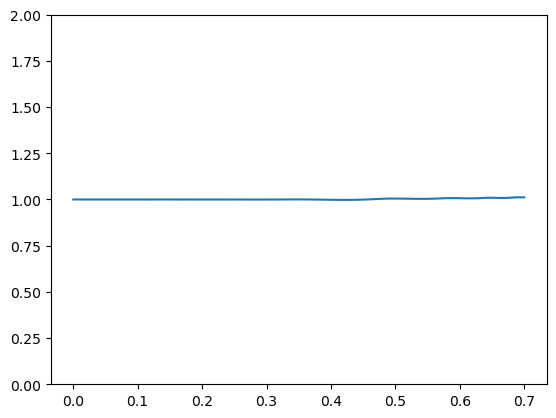

In [ ]:
plt.plot(t, As/A0)
plt.ylim([0, 2])

[<matplotlib.lines.Line2D>]

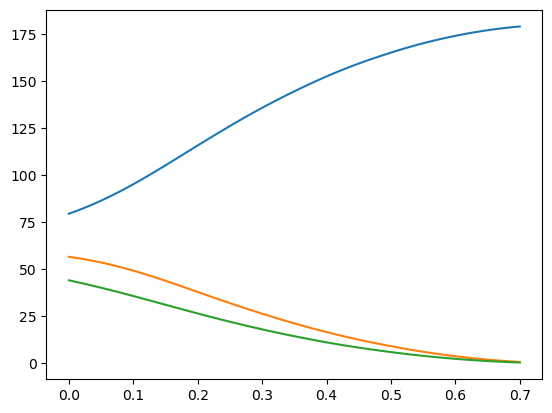

In [ ]:
plt.plot(t, angles[0])
plt.plot(t, angles[1])
plt.plot(t, angles[2])

In [ ]:
## naive Euler stepping - looks ok!

Ts = [y0,]
ts = [0,]

dt = .01

for i in range(70):
    ts.append(ts[-1]+dt)
    T_new = Ts[-1]+dt*excitable_dt(Ts[-1], m=2)
    Ts.append(T_new)
Ts = np.stack(Ts, axis=-1)
ts = np.array(ts)

[<matplotlib.lines.Line2D>]

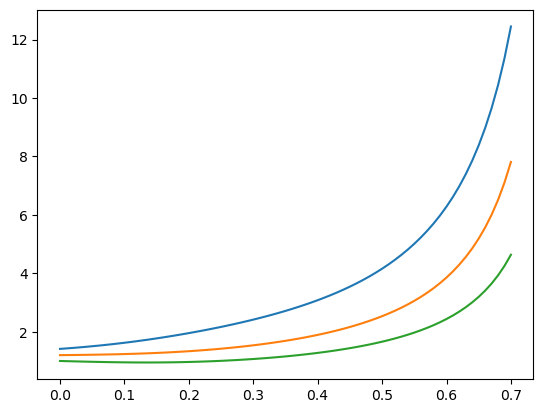

In [ ]:
plt.plot(ts, Ts[0])
plt.plot(ts, Ts[1])
plt.plot(ts, Ts[2])

## Subclassing

Instead of adding attributes/methods to the data structure classes defined in notebook `00`, we sub-class the data structure. This involves:

- adding `rest` and `passive` attributes to the `HalfEdge` class to represent internal total and passive tension 
- adding methods to set rest lenghts etc to the mesh class
- below, adding methods to flatten and time evolve the triangulation.


When subclassing, we simply construct the mesh using the base class methods and then replace the `HalfEdge`s with `TensionHalfEdge`s. We also allow to initialize from an existing  `HalfEdgeMesh`. [This link](https://numpy.org/doc/stable/user/basics.subclassing.html#basics-subclassing) might be helpful to understand how this is done using python's `__new__` and `__init__`.



Presumably the actual OOP way would be to use the factory design pattern to construct a mesh, and then assign its class (basic `HalfEdgeMesh`, `TensionHalfEdgeMesh`, future subclasses with attributes for real-space optimization), afterwards.

In [ ]:
#| export

@dataclass
class TensionHalfEdge(msh.HalfEdge):
    """Half edge with attributes storing total and active tension.""" 
    rest: Union[float, None] = None
    passive: float = 0.0

    def __repr__(self):
        repr_str = super().__repr__()
        repr_str = repr_str.replace('HalfEdge', 'TensionHalfEdge')
        if self.rest is not None and self.passive is not None:
            repr_str += f", rest={round(self.rest, ndigits=1)}, passive={round(self.passive, ndigits=1)}"
        return repr_str
    
    def unwrap(self, in_place=True):
        """Cast to HalfEdge base class."""
        he = self if in_place else copy(self)
        he.__class__ = msh.HalfEdge
        del he.rest
        del he.passive
        if not in_place:
            return the
        
    
@patch
def wrap_as_TensionHalfEdge(self: msh.HalfEdge, rest=None, passive=0.0, in_place=True
                           ) -> Union[None, TensionHalfEdge]:
    """
    In-place/copy upcast from HalfEdge to TensionHalfEdge.
    
    Internal, for use in TensionHalfEdgeMesh.__init__.
    """
    the = self if in_place else copy(self)
    the.__class__ = TensionHalfEdge
    the.rest = rest
    the.passive = passive
    if not in_place:
        return the

In [ ]:
mesh = msh.get_test_hemesh_large()
he = mesh.hes[10]
the = he.wrap_as_TensionHalfEdge(in_place=False)

print('returning a new object')
print(he)
print(the)

print('in place modification')
print(he)
he.wrap_as_TensionHalfEdge(in_place=True)
print(he)

print('in place unwrapping')
he.unwrap(in_place=True)
print(he)

returning a new object
HalfEdge(heid=10, nxt=11, prev=9, twin=5715, face=3, vertices=(35, 34), center=[0.4 0. ]
TensionHalfEdge(heid=10, nxt=11, prev=9, twin=5715, face=3, vertices=(35, 34), center=[0.4 0. ]
in place modification
HalfEdge(heid=10, nxt=11, prev=9, twin=5715, face=3, vertices=(35, 34), center=[0.4 0. ]
TensionHalfEdge(heid=10, nxt=11, prev=9, twin=5715, face=3, vertices=(35, 34), center=[0.4 0. ]
in place unwrapping
HalfEdge(heid=10, nxt=11, prev=9, twin=5715, face=3, vertices=(35, 34), center=[0.4 0. ]


In [ ]:
#| export

class TensionHalfEdgeMesh(msh.HalfEdgeMesh):
    """
    HalfEdgeMesh with methods for active triangulation dynamics.
    
    Can be instantiated from a HalfEdgeMesh, or from the more basal ListOfVerticesAndFaces.
    """
    def __new__(cls, mesh: Union[msh.HalfEdgeMesh, None]= None):
        if isinstance(mesh, msh.HalfEdgeMesh):
            mesh = deepcopy(mesh)
            mesh.__class__ = cls
            return mesh
        else:
            return super().__new__(cls)
    def __init__(self, mesh: Union[msh.ListOfVerticesAndFaces, msh.HalfEdgeMesh]):
        if isinstance(mesh, msh.ListOfVerticesAndFaces):
            super().__init__(mesh)
        for he in self.hes.values():
            he.wrap_as_TensionHalfEdge(in_place=True)
            
    def save_mesh(self, fname: str, save_rest_passive=False) -> None:
        super().save_mesh(fname)
        if save_rest_passive:
            pickle.dump({key: val.rest for key, val in self.hes.items()}, open(f"{fname}_rest.p", "wb"))
            pickle.dump({key: val.passive for key, val in self.hes.items()}, open(f"{fname}_passive.p", "wb"))
    save_mesh.__doc__ = (msh.HalfEdgeMesh.save_mesh.__doc__
                         +'\n Can also pickle passive&rest attributes as dicts at fname_{rest/passive}.p')
    
    def unwrap(self):
        """In-place cast to HalfEdgeMesh base class."""
        self.__class__ = msh.HalfEdgeMesh
        for he in self.hes.values():
            he.unwrap(in_place=True)
    
    @staticmethod
    def load_mesh(fname: str, load_rest_passive=False):
        """
        Load from file as saved by mesh.save_mesh.
        
        Can load rest/passive attributes of half edges, if saved as pickled dicts at fname_{rest/passive}.p
        """
        mesh = TensionHalfEdgeMesh(super(TensionHalfEdgeMesh, TensionHalfEdgeMesh).load_mesh(fname))
        if load_rest_passive:
            rest_dict = pickle.load(open(f'{fname}_rest.p', 'rb'))
            passive_dict = pickle.load(open(f'{fname}_passive.p', 'rb'))
            for key, he in mesh.hes.items():
                he.rest = rest_dict[key]
                he.passive = passive_dict[key]
        return mesh

In [ ]:
mesh = msh.get_test_hemesh_large()
tmesh = TensionHalfEdgeMesh(mesh)

tmesh2 = TensionHalfEdgeMesh(mesh.to_ListOfVerticesAndFaces())

mesh.is_consistent(), tmesh.is_consistent(), tmesh2.is_consistent()

(True, True, True)

In [ ]:
TensionHalfEdgeMesh.load_mesh('test_save.txt')

<__main__.TensionHalfEdgeMesh>

In [ ]:
help(TensionHalfEdgeMesh.load_mesh)

Help on function load_mesh in module __main__:

load_mesh(fname: str, load_rest_passive=False)
    Load from file as saved by mesh.save_mesh.
    
    Can load rest/passive attributes of half edges, if saved as pickled dicts at fname_{rest/passive}.p



In [ ]:
tmesh.faces[10].hes

[TensionHalfEdge(heid=31, nxt=32, prev=30, twin=23, face=10, vertices=(1132, 1157), center=[0.3 0.9],
 TensionHalfEdge(heid=32, nxt=30, prev=31, twin=27, face=10, vertices=(1157, 1131), center=[0.3 0.9],
 TensionHalfEdge(heid=30, nxt=31, prev=32, twin=196, face=10, vertices=(1131, 1132), center=[0.3 0.9]]

In [ ]:
tmesh.hes[31].face.hes

[TensionHalfEdge(heid=31, nxt=32, prev=30, twin=23, face=10, vertices=(1132, 1157), center=[0.3 0.9],
 TensionHalfEdge(heid=32, nxt=30, prev=31, twin=27, face=10, vertices=(1157, 1131), center=[0.3 0.9],
 TensionHalfEdge(heid=30, nxt=31, prev=32, twin=196, face=10, vertices=(1131, 1132), center=[0.3 0.9]]

In [ ]:
#| export

@patch
def set_rest_lengths(self: TensionHalfEdgeMesh) -> None:
    """Set the triangulation rest lengths to current lengths"""
    for key, val in self.get_edge_lens().items():
        self.hes[key].rest = val

In [ ]:
tmesh.set_rest_lengths()

tmesh.hes[53], tmesh.faces[17].hes[0]

(TensionHalfEdge(heid=53, nxt=51, prev=52, twin=9, face=17, vertices=(35, 10), center=[0.4 0. ], rest=0.0, passive=0.0,
 TensionHalfEdge(heid=53, nxt=51, prev=52, twin=9, face=17, vertices=(35, 10), center=[0.4 0. ], rest=0.0, passive=0.0)

## Optimize vertex positions given rest lengths

Using JAX to compute the gradient of the energy function.

We define a function to measure energy $=\sum_e (l_e -l_{e,0})^2$. For compatibility with `scipy.optimize`, it needs to take in a 1d vector of vertex positions of shape. Here is a little test case on how this can be done

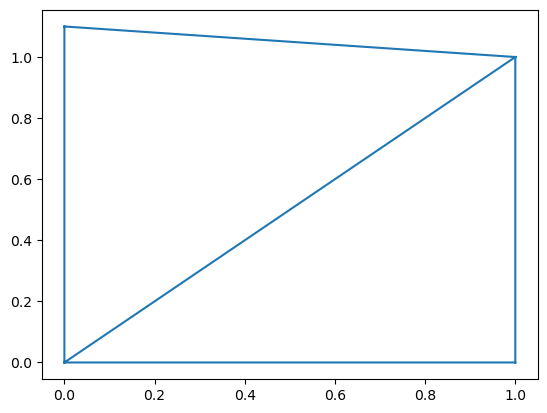

In [ ]:
mesh = TensionHalfEdgeMesh(msh.get_test_hemesh())
mesh.triplot()

In [ ]:
# create a test vector

for he in mesh.hes.values():
    he.rest = 1.5 # for testing purposes

In [ ]:
# step 0: prepare initial condition. will serve as test vector. sort vectors by keys.

vertex_keys = sorted(mesh.vertices.keys())
vertex_vector = np.stack([mesh.vertices[key].coords for key in vertex_keys]).T

# scipy otpmize needs a 1d array. so stack x coords on top of y coords
x0 = np.hstack([vertex_vector[0], vertex_vector[1]])

In [ ]:
#%%time

# step 1: create a list of initial & terminal edge vertices. this will be used to calculate differences
# also create a reference vector of 

e_lst = []
rest_lengths = []

# we will need to look up which vertex key corresponds to list position
vertex_key_dict = {key: ix for ix, key in enumerate(sorted(mesh.vertices.keys()))}

for e in mesh.hes.values():
    if e._verticesid[0] < e._verticesid[1]: # avoid duplicates
        e_lst.append([vertex_key_dict[v._vid] for v in e.vertices])
        rest_lengths.append((e.rest+e.twin.rest)/2)
        
e_lst = np.array(e_lst).T
rest_lengths = np.array(rest_lengths)

# step 2 split up the vector and calculate lengths

x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
print((x[e_lst[0]]-x[e_lst[1]]), (y[e_lst[0]]-y[e_lst[1]]))  # looks good
lengths = np.sqrt((x[e_lst[0]]-x[e_lst[1]])**2 + (y[e_lst[0]]-y[e_lst[1]])**2)

E = 1/2 * (lengths-rest_lengths)**2

[-1.  0. -1. -1.  0.] [ 0.  -1.  -1.   0.1 -1.1]


### Wrapping for JAX

To efficiently optimize the vertex positions, we need the gradient of the "elastic energy". This is done by automatic differentiation using JAX. However, JAX cannot just differentiate any code : it needs a side-effect free function from `numpy` arrays to scalars. Here, we construct a method that "serializes" a `HalfEdgeMesh` to a bunch of arrays (think adjacency matrices), and an energy function which computes the elastic energies using those arrays as keyword args (and which will also conform with the syntax of the `scipy.optimize` module).

In the energy function, we include a regularization term for the triangle areas to ensure they neither collapse, explode, or flip.

In [ ]:
#| export

@patch
def vertices_to_vector(self: TensionHalfEdgeMesh, flattened=True) -> NDArray[Shape["*"],Float]:
    """
    Format vertex coordinates for use in energy minimization.  
    
    If flattened, 1st n_vertices/2 entries of vector are the x-, 2nd n_vertices/2 entries the y-coords.
    Else, return n_vertices * 2 array
    """
    vertex_keys = sorted(self.vertices.keys())
    vertex_vector = np.stack([self.vertices[key].coords for key in vertex_keys])
    if flattened:
        return vertex_vector.reshape(2*vertex_vector.shape[0])
    return vertex_vector
       
@patch
def vector_to_vertices(self: TensionHalfEdgeMesh, x0, flattened=True) -> Dict[int, NDArray[Shape["2"],Float]]:
    """Reverse of vertices_to_vector - format output of energy minimization as dict."""
    vertex_keys = sorted(self.vertices.keys())
    if flattened:
        vertex_vector = x0.reshape((int(x0.shape[0]/2), 2))
    else:
        vertex_vector = x0
    return {key: val for key, val in zip(vertex_keys, vertex_vector)}

#### JAX based energy function

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.nn import relu as jrelu
from jax.tree_util import Partial
from jax.config import config

config.update("jax_enable_x64", True) 

In [ ]:
#| export

@jit
def polygon_area(pts: NDArray[Shape["*,2,..."], Float]) -> NDArray[Shape["2,..."], Float]:
    """JAX-compatible - area of polygon. Assuming no self-intersection. Pts.shape (n_vertices, 2)"""
    return jnp.sum(pts[:,0]*jnp.roll(pts[:,1], 1, axis=0) - jnp.roll(pts[:,0], 1, axis=0)*pts[:,1], axis=0)/2

@jit
def polygon_perimeter(pts: NDArray[Shape["*,2,..."], Float]) -> NDArray[Shape["2,..."], Float]:
    """JAX-compatible - perimeter of polygon. Assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return jnp.sum(jnp.linalg.norm(pts-jnp.roll(pts, 1, axis=0), axis=1), axis=0)

In [ ]:
#| export

@patch
def get_dual_energy_fct_jax(self: TensionHalfEdgeMesh):
    """
    JAX-compatible - Get arrays for triangulation flattening.
    
    "Serializes" a HalfEdgeMesh into a bunch of arrays which can be used by a JAX-compatible
    function to compute the "elastic energy" used to flatten a triangulation.
    
    Returns
    -------
    
    e_lst : (n_edges, 2) array
        Indices to the serialized vertex positions defining edges in triangulation
    rest_lengths : (n_edges) array
        Rest lengths of each edge
    tri_lst : (n_triangles, 3) array
        Indices to the serialized vertex positions defining tr iangles in triangulation
    """
    e_lst = []
    tri_lst = []
    rest_lengths = []

    # we will need to look up which vertex key corresponds to list position
    vertex_key_dict = {key: ix for ix, key in enumerate(sorted(self.vertices.keys()))}
    
    for e in self.hes.values():
        if e.duplicate: # avoid duplicates
            e_lst.append([vertex_key_dict[v._vid] for v in e.vertices])
            rest_lengths.append((e.rest+e.twin.rest)/2)
    e_lst = jnp.array(e_lst).T
    rest_lengths = jnp.array(rest_lengths)
    
    for fc in self.faces.values():
        tri_lst.append([vertex_key_dict[he.vertices[0]._vid] for he in fc.hes][::-1])
    tri_lst = jnp.array(tri_lst).T
    n_vertices = len(self.vertices)
    
    return e_lst, rest_lengths, tri_lst

In [ ]:
#| export

@jit
def get_E_dual(x0: NDArray[Shape["*"],Float], e_lst: NDArray[Shape["*, 2"],Float],
               rest_lengths: NDArray[Shape["*"],Float], tri_lst: NDArray[Shape["*, 3"],Float],
               mod_area=0.01, A0=jnp.sqrt(3)/4) -> float:
    """
    Dual energy function for triangulation flattening
    
    Compute the deviation of a set of vertex positions from the desired rest lengths 
    sum_e (|x_i-x_j| - l_e)^2, plus regularization term for triangle areas.
    Uses x0, the serialized vector of vertex positions, and the arrays returned by
    HalfEdgeMesh.get_dual_energy_fct_jax.
    
    Performance note: calling this function for meshes with different numbers of
    edges & vertices will trigger JIT-recompilation which can be slow. Calling on meshes with the
    same number of edges & vertices (e.g. related by T1s) is OK.

    Parameters
    ----------
    x0: (2*n_vertices,) array
        Vertex position vector as created by HalfEdgeMesh.vector_to_vertices.
    e_lst, rest_lengths, tri_lst: arrays
        Created by HalfEdgeMesh.get_dual_energy_fct_jax
    mod_area: float
        Strength of area regularization
    A0: float
        Triangle reference area for area regularization 
    
    Returns
    -------
    float
        elastic energy
    
    """
    pts = x0.reshape((int(x0.shape[0]/2), 2))
    
    lengths = jnp.linalg.norm(pts[e_lst[0]]-pts[e_lst[1]], axis=1)
    E_length = 1/2 * jnp.sum((lengths-rest_lengths)**2)
    # triangle area penalty
    A = polygon_area(pts[tri_lst].transpose((0,2,1)))
    # orientation penalty:
    E_area = mod_area/2 *(100*jnp.sum(jrelu(-A+A0/4)**2) + jnp.sum((A-A0)**2))
    # relu term penalizes 'flipped' triangles with incorrect orientation.
    
    return E_length + E_area
  
get_E_dual_jac = jit(jgrad(get_E_dual))
# static_argnums is required since n_vertices is used to slice the input array - else, jit fails.

<matplotlib.collections.LineCollection>

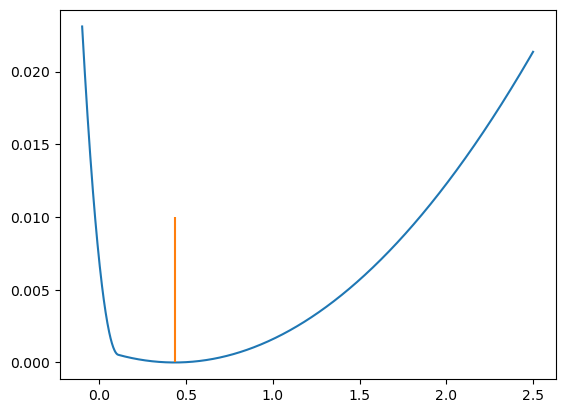

In [ ]:
## plotting the regularization potential

A0 = np.sqrt(3)/4
As = np.linspace(-.1, 2.5, 1000)
V_A = 1/2 * (jrelu(-As+A0/4)**2 + 0.01*(As-A0)**2)

plt.plot(As, V_A)
plt.vlines(A0, 0, .01, color='tab:orange')

In [ ]:
test_hemesh_large = TensionHalfEdgeMesh(msh.get_test_hemesh_large())
for he in test_hemesh_large.hes.values():
    he.rest = 1.5

x0 = test_hemesh_large.vertices_to_vector()
energy_arrays = test_hemesh_large.get_dual_energy_fct_jax()

In [ ]:
%timeit get_E_dual(x0, *energy_arrays)

47.9 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit get_E_dual_jac(x0, *energy_arrays)

183 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Minimizing the dual energy

To minimize the dual energy, we use the conjugate gradient method from `scipy.optimize`. In order to minimize book-keeping, we wrap the process (creating the initial condition, serializing the mesh, re-setting the vertex positions) in a method which we add to the `HalfEdgeMesh` class.

In [ ]:
#| export

@patch
def flatten_triangulation(self: TensionHalfEdgeMesh, tol=1e-4, verbose=True, mod_area=0.01, A0=jnp.sqrt(3)/4,
                          reset_intrinsic=True, return_sol=False) -> Union[None, Dict]:
    """
    Flatten triangulation - optimize vertex positions to match intrinsic lengths.
    
    This wrapper does the following:
    1) Serialize a HalfEdgeMesh into arrays using HalfEdgeMesh.get_dual_energy_fct_jax
    and HalfEdgeMesh.vector_to_vertices
    2) Optimize the dual energy function get_E_dual using conjugate gradient implemented
    by scipy.optimize.minimize
    3) De-serialize the result and update the vertex positions
    4) Optionally, re-set the intrinsic lengths to match the phyiscal edge lengths
    
    Performance note: calling this function for meshes with different numbers of
    edges & vertices will trigger JIT-recompilation which can be slow. Calling on meshes with the
    same number of edges & vertices (e.g. related by T1s) is OK.
    
    Parameters
    ----------
    tol : float
        Optimizer tolerance
    verbose : bool
        Print warnings if optimization fails
    mod_area : float
        Area regularization, passed on to get_E_dual
    A0 : float
        Reference triangle area, passed on to get_E_dual
    reset_intrinsic : bool
        Reset intrinsic lengths after optimization
    return_sol : bool
        Return optimizer result dict
    """
    energy_arrays = self.get_dual_energy_fct_jax()
    x0 = self.vector_to_vertices()
    sol = optimize.minimize(get_E_dual, x0, method="CG", jac=get_E_dual_jac, tol=tol, # CG, BFGS
                            args=energy_arrays+(mod_area, A0))
    sol['initial_fun'] = float(get_E_dual(x0, *(energy_arrays+(mod_area, A0))))
    if sol["status"] !=0 and verbose:
        print("Triangulation optimization failed")
        print(sol["message"])
    new_coord_dict = self.vertices_to_vector(sol["x"])
    for key, val in self.vertices.items():
        val.coords = new_coord_dict[key]
    if reset_intrinsic:
        self.set_rest_lengths()
    if return_sol:
        return sol

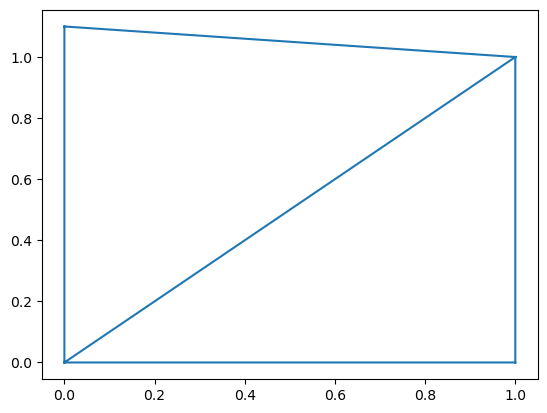

In [ ]:
# create a test case

mesh = TensionHalfEdgeMesh(msh.get_test_hemesh())
for he in mesh.hes.values():
    he.rest = 1.5 # for testing purposes
mesh.triplot()

In [ ]:
%time sol = mesh.flatten_triangulation(return_sol=True)

sol['fun'], sol['initial_fun']

CPU times: user 4.83 ms, sys: 77 µs, total: 4.91 ms
Wall time: 3.66 ms


(0.0028650057156245495, 0.0028864107972841856)

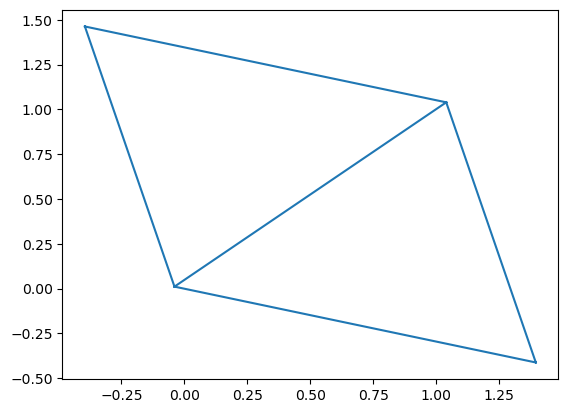

In [ ]:
mesh.triplot()

### Try a larger mesh

In [ ]:
# try a more difficult task - larger mesh

test_hemesh_large = TensionHalfEdgeMesh(msh.get_test_hemesh_large())

edge_lengths = test_hemesh_large.get_edge_lens()
for e, val in edge_lengths.items():
    test_hemesh_large.hes[e].rest = val + np.random.normal(scale=1e-2)
    #mesh.hes[e].rest = 1.01*val

In [ ]:
%timeit sol = test_hemesh_large.flatten_triangulation(reset_intrinsic=False, return_sol=True, mod_area=1e-5)

sol['fun'], sol['initial_fun']  # note: random intrinsic lengths are hard to satisfy 

81.2 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(0.0028650057156245495, 0.0028864107972841856)

## Euler step for whole triangulation

Example of how to evolve a mesh in time. Euler step the rest lengths, flatten the triangulation, repeat. 

In [ ]:
mesh = TensionHalfEdgeMesh(msh.get_test_hemesh())
mesh.set_rest_lengths()

[val.hes for val in mesh.faces.values()]

[[TensionHalfEdge(heid=0, nxt=1, prev=2, twin=6, face=0, vertices=(0, 2), center=[0.5 0. ], rest=1.0, passive=0.0,
  TensionHalfEdge(heid=1, nxt=2, prev=0, twin=7, face=0, vertices=(2, 3), center=[1.  0.5], rest=1.0, passive=0.0,
  TensionHalfEdge(heid=2, nxt=0, prev=1, twin=3, face=0, vertices=(3, 0), center=[0.5 0.5], rest=1.4, passive=0.0],
 [TensionHalfEdge(heid=3, nxt=4, prev=5, twin=2, face=1, vertices=(0, 3), center=[0.5 0.5], rest=1.4, passive=0.0,
  TensionHalfEdge(heid=4, nxt=5, prev=3, twin=8, face=1, vertices=(3, 1), center=[0.5 1. ], rest=1.0, passive=0.0,
  TensionHalfEdge(heid=5, nxt=3, prev=4, twin=9, face=1, vertices=(1, 0), center=[0.  0.6], rest=1.1, passive=0.0]]

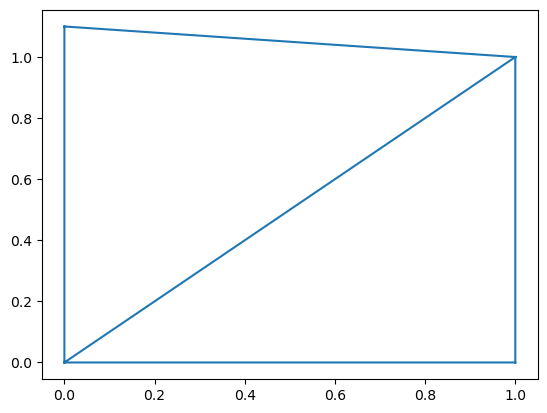

In [ ]:
mesh.triplot()

In [ ]:
# Euler step all the rest lengths of a mesh (as long as they are not None)

m = 2
dt = .001

for fc in mesh.faces.values():
    # collect edges
    Ts = np.array([he.rest for he in fc.hes])
    Ts += dt*excitable_dt(Ts, m=2)
    for T, he in zip(Ts, fc.hes):
        he.rest = T

In [ ]:
%%time

# now let"s try a full loop with optimization

m = 2
dt = .01

for i in range(15):
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    mesh.flatten_triangulation(reset_intrinsic=True)

CPU times: user 48.8 ms, sys: 0 ns, total: 48.8 ms
Wall time: 47.3 ms


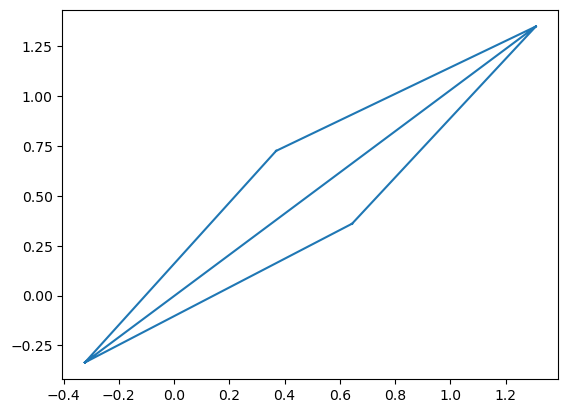

In [ ]:
mesh.triplot()

True


(-0.35000000000000003, 7.35, -0.35000000000000003, 7.35)

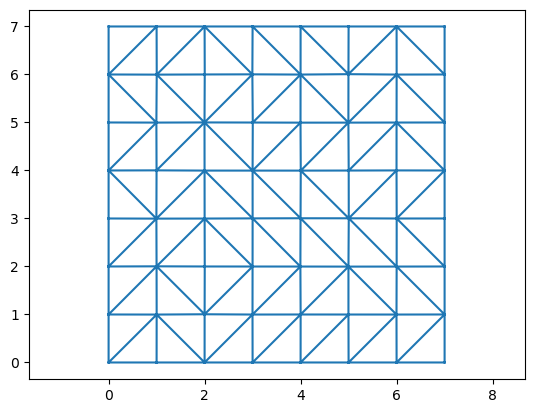

In [ ]:
## and now with a larger mesh

mesh = TensionHalfEdgeMesh(msh.get_test_hemesh_large(x=np.arange(8.), y=np.arange(8.)))
mesh.set_rest_lengths()
print(mesh.is_consistent())

mesh.triplot()
plt.axis("equal")

In [ ]:
%%time

m = 2
dt = .01

for i in range(20):
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    mesh.flatten_triangulation(reset_intrinsic=True)        

CPU times: user 890 ms, sys: 0 ns, total: 890 ms
Wall time: 881 ms


(-0.9683087440716411,
 8.207259816781692,
 -0.8819975624502658,
 7.927731347947477)

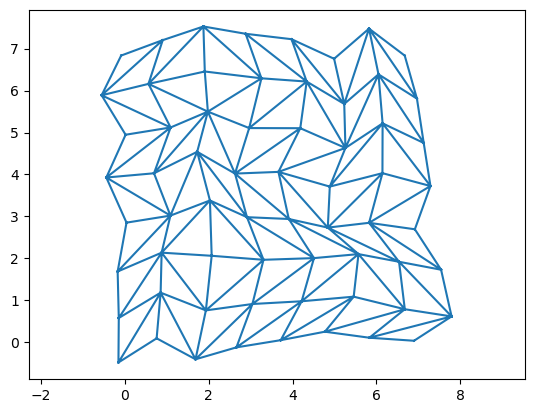

In [ ]:
mesh.triplot()
plt.axis("equal")

## Edge flips

The time evolution under positive feedback generates more and more obtuse triangles. If a kite (= 2 triangles sharing an edge) becomes very obtuse, we implement a T1 transition, i.e. we flip the interior edge. In real space, this corresponds to the collapse of an edge under high tension.

In this notebook, we deal purely with the tension dynamics - real space will be considered next. As a preliminary way to decide whether to flip an edge, we use the Delaunay criterion $\phi_k+\phi_l \leq \pi$, where $\phi_k, \phi_l$ are the two angles opposite to an edge in a kite.


#### Get mesh angles for Delauny condition


In [ ]:
#| export

@patch
def get_angles(self: TensionHalfEdgeMesh) -> Dict[int, float]:
    """Get the angle opposite to each half edge in the mesh."""
    angle_dict = {}
    egde_lengths = self.get_edge_lens()
    for fc in self.faces.values():
        heids = [he._heid for he in fc.hes]
        angles = sides_angles([egde_lengths[e] for e in heids]) 
        for e, a in zip(heids, angles):
            angle_dict[e] = a   
    return angle_dict

@patch
def get_double_angles(self: TensionHalfEdgeMesh) -> Dict[int, float]:
    """Get the sum of the opposite angles of an edge (2x half edge) in mesh, e.g. for Delaunay criterion."""
    angles = self.get_angles()
    double_angles = {he._heid: (angles[he._heid]+angles[he._twinid]) for he in self.hes.values()
                             if (he.face is not None) and (he.twin.face is not None)}
    return double_angles

flip  56


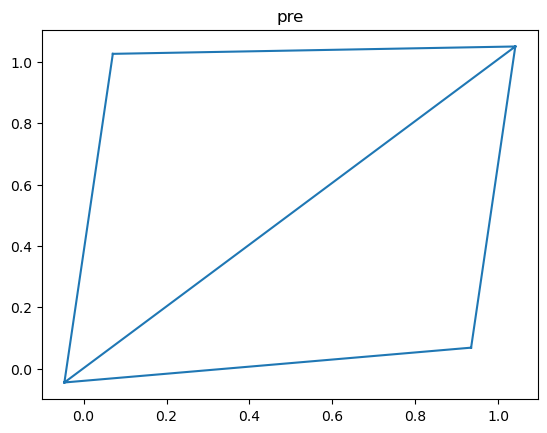

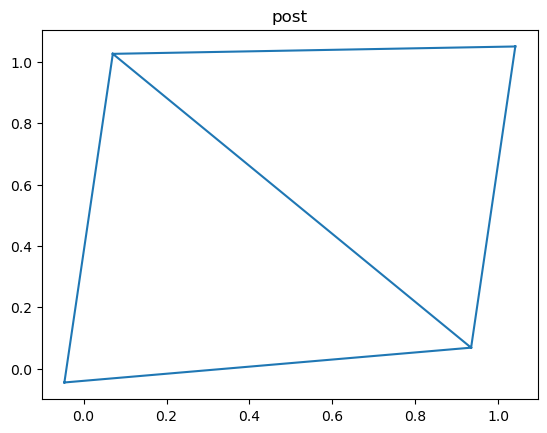

flip  171


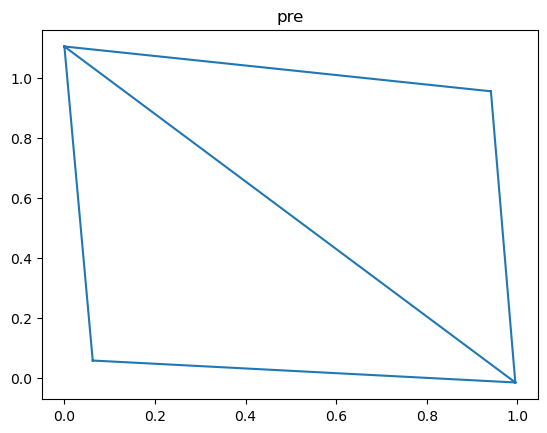

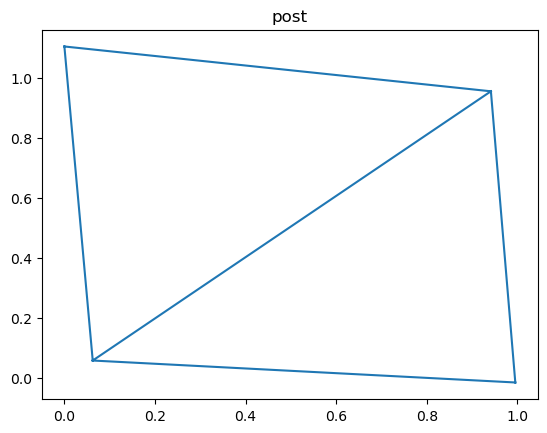

flip  295


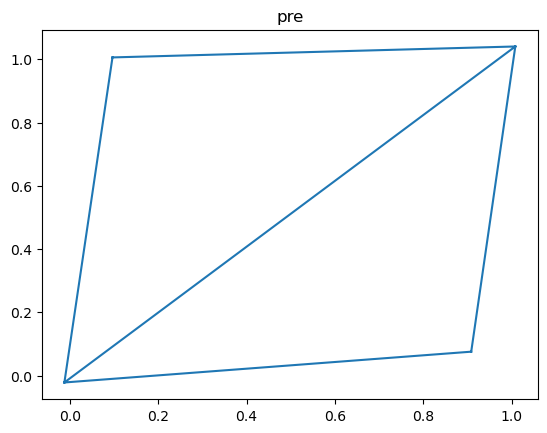

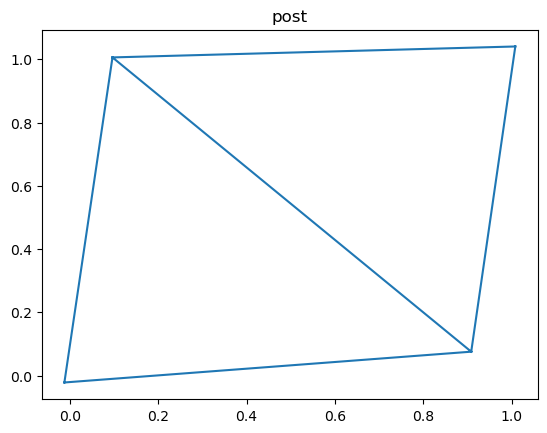

In [ ]:
# example of a full optimization loop with flips

mesh = TensionHalfEdgeMesh(msh.get_test_hemesh())
mesh.set_rest_lengths()

m = 2
dt = .001

meshes = [mesh]
times = [0]

for i in range(300):
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    mesh.flatten_triangulation(reset_intrinsic=True)
    # compute angles and carry out an edge flip if required
    angles = mesh.get_double_angles()
    argmax = max(angles, key=angles.get)
    if angles[argmax] > 200 * (np.pi/180):
        print("flip ", i)
        mesh.triplot()
        plt.title("pre")
        plt.show()
        
        mesh.flip_edge(argmax)
        mesh.set_rest_lengths()

        mesh.triplot()
        plt.title("post")
        plt.show()
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

### Passive tension

As can be seen above, the active tension feedback leads to flip-flopping T1s. This is because post T1, the collapsing edge is in general still the edge with highest tension, so under naive feedback, its tension will continue to grow.

This is solved by the myosin handover mechanism. Post T1, the amount of total tension on an edge is lower than its active tension. This is balanced by passive tension, which decays viscously. Here, we implement tension feedback with passive tension, a wrapper for Euler stepping the triangulation, and the code required for the myosin handover post T1. 

In [ ]:
#| export

def excitable_dt_act_pass(Ts: NDArray[Shape["3"], Float], Tps: NDArray[Shape["3"], Float], k=1, m=2, k_cutoff=0,
                          ) -> Tuple[NDArray[Shape["3"],Float],NDArray[Shape["3"],Float]]:
    """
    Time derivative of tensions under excitable tension model, including passive tension.
    
    Implements the following equations:
        d_dt T = T^m
        d_dt T_passive = -k*T_passive
    
    with the following additions:
        - a -k_cutoff*T^(m+1) term which cuts of excitable feedback at large tensions for numerical stability
        - projection of the d_dt T - vector on triangle-area-preserving edge length changes
    
    For m==1 (no excitable tension feedback), we implement a special case:
        d_dt T = -k*(T-1)
    i.e. tensions relax back to equilateral. This will be useful later to model completely
    passive edges with no excitable dynamics.
    
    Parameters
    ----------
    Ts : (3,) array
        active tensions
    Tps : (3,) array
        passive tensions
    k : float
        passive tension relaxation rate
    m : float
        excitable tension exponent
    k_cutoff : 
        cutoff for excitable tension. 0 = no cutoff.
        
    Returns
    -------
    dT_dt : (3,) array
        time derivative of active tension
    dTp_dt : (3,) array
        time derivative of passive tension


    """
    dT_dt = (m!=1)*((Ts-Tps)**m - k_cutoff*(Ts-Tps)**(m+1) - k*Tps) - k*(m==1)*(Ts-1)    
    dTp_dt = -k*Tps
    area_jac = sides_area_jac(Ts-Tps)
    area_jac /= np.linalg.norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)    
    return dT_dt, dTp_dt

In [ ]:
#| export

@patch
def reset_rest_passive_flip(self: TensionHalfEdgeMesh, e: TensionHalfEdge, method="smooth") -> None:
    """
    Reset rest length and passive tensions of flipped he according to myosin handover.
    
    Two options: "smooth" results in contiuous rest lengths, using the passive contruction,
    "direct" directly sets the rest length to the values of the neighbors.
    """
    twin = e.twin
    rest_pre = (e.rest+twin.rest)/2
    rest_neighbors = (e.nxt.rest+e.prev.rest+twin.nxt.rest+twin.prev.rest)/4
    if method == "smooth":
        e.rest = np.linalg.norm(e.vertices[0].coords - e.vertices[1].coords)
        e.passive = (rest_pre+e.rest)-2*rest_neighbors
        twin.rest, twin.passive = (e.rest, e.passive)
    elif method == "direct":
        e.rest = rest_neighbors
        e.passive = rest_pre-rest_neighbors
        twin.rest, twin.passive = (e.rest, e.passive)
    else:
        print("method must be smooth or direct")

In [ ]:
#| export

@patch
def euler_step(self: TensionHalfEdgeMesh, dt=.005, rhs_tension=excitable_dt_act_pass, params=None,
               rhs_rest_shape: Union[None, callable]=None) -> None:
    """
    Euler step intrinsic edge length and reference shapes. 
    
    Iterates over mesh triangles and cells, updating the intrinsic properties (active and passive tensions,
    reference shapes) using the provided ODE RHS functions.
    
    Implements spatial patterning of the tension evolution equations via the params keyword.
    
    Parameters
    ----------
    dt : float
        Time step
    rhs_tension : callable
        Function which takes arguments (T_active, T_passive) and returns their time derivatives
    params : dict or callable
        Parameters for the rhs_tension function. Can be a function from face ids -> parameter dict,
        allowing different triangles to evolve differently.
    rhs_rest_shape : callable
        Function which takes a vertex as argument and returns the time derivative of the rest shape
        (e.g. viscous relaxation). If None, the function returns 0.
    
    """
    rhs_rest_shape = (lambda v: 0) if rhs_rest_shape is None else rhs_rest_shape
    # Euler step edges
    for fc in self.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        if isinstance(params, dict):
            dT_dt, dTp_dt = rhs_tension(Ts, Tps, **params)
        elif callable(params):
            dT_dt, dTp_dt = rhs_tension(Ts, Tps, **params(fc._fid))
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    # Euler step cells
    for v in self.vertices.values():
        v.rest_shape += dt*rhs_rest_shape(v)

### Example of time evolution with passive tension - should yield a permanent intercalation

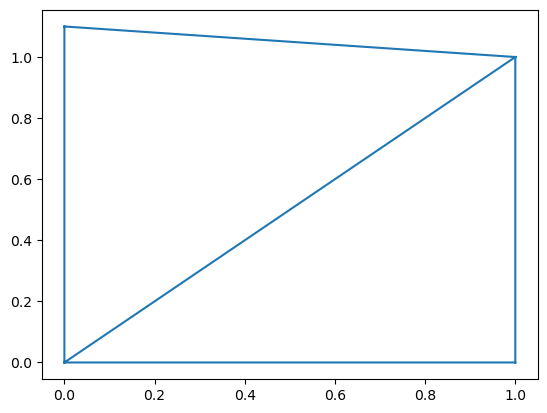

In [ ]:
mesh_initial = TensionHalfEdgeMesh(msh.get_test_hemesh())
mesh_initial.set_rest_lengths()

mesh_initial.triplot()
plt.show()

In [ ]:
## set parameters

m = 2
k = 1
dt = .01

param_dict = {'m': m, 'k': k}

In [ ]:
%%time

meshes = [deepcopy(mesh_initial)]
mesh = deepcopy(meshes[-1])
times = [0]

for i in range(30):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=excitable_dt_act_pass, params=param_dict)
    # flatten
    mesh.flatten_triangulation(reset_intrinsic=True)
    # compute angles and carry out an edge flip if required
    angles = mesh.get_double_angles()
    flip_edge = max(angles, key=angles.get)
    if angles[flip_edge] > 220 * (np.pi/180):
        print("flip ", i)
        he = mesh.hes[flip_edge]
        try:
            mesh.flip_edge(flip_edge)
        except ValueError:
            break
        # resetting the active and passive tensions
        mesh.reset_rest_passive_flip(mesh.hes[argmax])
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

flip  11
CPU times: user 89.5 ms, sys: 3.85 ms, total: 93.3 ms
Wall time: 91.8 ms


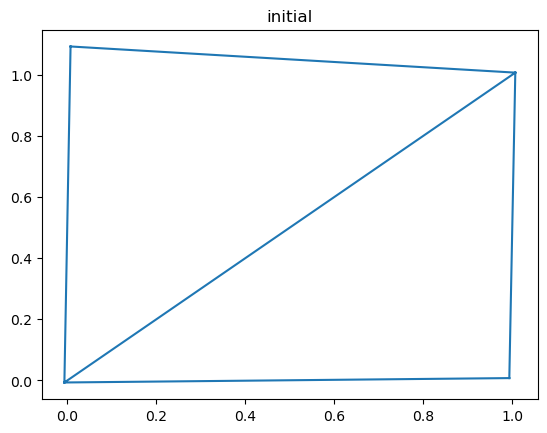

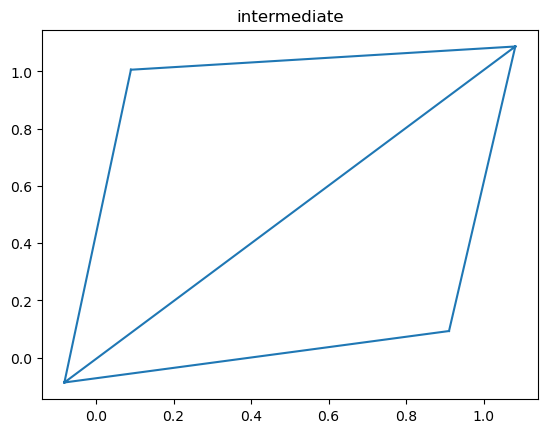

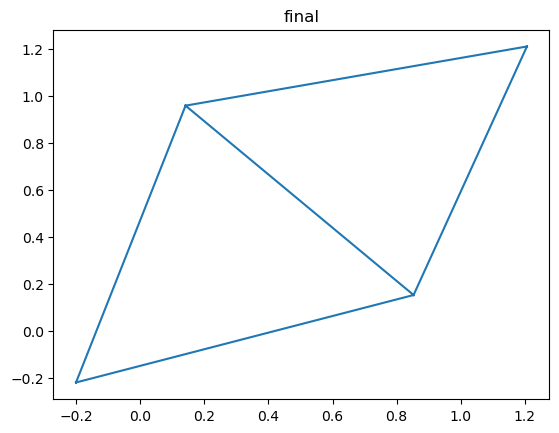

In [ ]:
meshes[1].triplot()
plt.title("initial")
plt.show()


meshes[10].triplot()
plt.title("intermediate")
plt.show()


meshes[-1].triplot()
plt.title("final")
plt.show()


## Export code

In [ ]:
#| hide
nbdev.nbdev_export()